# Differential photometry

In this tutorial we will produce a transit light curve of WASP-12 b using the images from the [photometry dataset](datasets). We'll apply differential photometry techniques to detect the small dip in brightness that occurs when this exoplanet passes in front of its host star.
## Files selection

Our analysis will simply start from the calibrated images produced in the [calibration tutorial](calibration). Like in previous tutorials we will order these images by the date specified in the `DATE-OBS` header keyword. 

In [1]:
from astropy.io import fits
from dateutil import parser
from glob import glob

images = glob("calibrated_images/ESPC*.fits")


def observation_time(file):
    date_str = fits.getheader(file)["DATE-OBS"]
    return parser.parse(date_str)


# order by observation time
images = sorted(images, key=lambda file: observation_time(file))

## Reference image

We will now select the stars from which we want the photometry. As a reference image let's use the stack image we previously produced.

In [2]:
# reference
reference_file = "calibrated_images/stack_image.fits"

This reference frame will be used to align other images and to detect the stars present in the field of view, stars from which we will extract the photometry in all remaining images.

In order to detect these reference stars, we will start by calibrating our reference image. 

```{note}
As the calibration and detection sequence (plus some other image processing tasks like trimming and PSF modeling) also need to be ran for the other images, let's create a function we can reuse later.
```

In [3]:
import numpy as np
from eloy import psf, detection, utils

trim = 10
n_stars_align = 12


def calibration_sequence(file):
    # getting data
    data = fits.getdata(file)
    header = fits.getheader(file)

    # trimming
    calibrated_data = data[trim:-trim, trim:-trim]
    # detection
    regions = detection.stars_detection(calibrated_data)
    # stars coords and cutouts
    region_coords = np.array([(r.centroid[1], r.centroid[0]) for r in regions])
    cutouts = utils.cutout(calibrated_data, region_coords, (50, 50))

    # epsf modeling
    cutouts_normalized = cutouts / np.nanmax(cutouts, (1, 2))[:, None, None]
    epsf = np.nanmedian(cutouts_normalized, 0)
    psf_params = psf.fit_gaussian(epsf)
    fwhm = psf.gaussian_sigma_to_fwhm * np.mean(
        [psf_params["sigma_x"], psf_params["sigma_y"]]
    )

    del (
        cutouts_normalized,
        data,
        regions,
        cutouts,
        epsf,
        header,
    )

    return calibrated_data, region_coords, fwhm

Let's apply this function on the reference image and plot the detected stars.

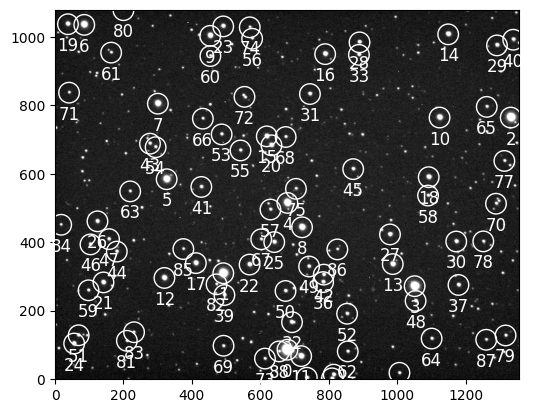

In [4]:
import matplotlib.pyplot as plt
from eloy import alignment, viz

ref_data, ref_coords, ref_fwhm = calibration_sequence(reference_file)
ref_reference = alignment.twirl_reference(ref_coords[0:n_stars_align])

plt.imshow(viz.z_scale(ref_data), cmap="Greys_r", origin="lower")
viz.plot_marks(*ref_coords.T, color="w", label=True, ms=30)

## Photometry

The core of our analysis relies on aperture photometry, where we measure stellar brightness by summing the pixel values within circular apertures centered on each star. This approach allows us to capture the total flux from a star while excluding as much background light as possible. We'll test multiple aperture sizes relative to the seeing conditions (measured by the {term}`PSF`'s {term}`FWHM`) to determine the optimal radius that maximizes signal while minimizing noise.

In [5]:
from tqdm.auto import tqdm
from skimage.transform import AffineTransform
from eloy.ballet import Ballet
from astropy.time import Time
from collections import defaultdict
from eloy import centroid, photometry

n_stars = 20
relative_apertures_radii = np.linspace(0.1, 5, 40)
cnn = Ballet()

data = defaultdict(list)

for file in tqdm(images):
    calibrated_data, coords, fwhm = calibration_sequence(file)

    # alignment
    R = alignment.rotation_matrix(coords[0:n_stars_align], ref_coords, ref_reference)
    transform = AffineTransform(R).inverse
    aligned_coords = transform(ref_coords)[0:n_stars]
    dx, dy = np.median(ref_coords[0:n_stars] - aligned_coords, 0)

    # centroiding
    centroid_coords = centroid.ballet_centroid(calibrated_data, aligned_coords, cnn)
    # aperture photometry
    apertures_radii = relative_apertures_radii * fwhm
    flux = photometry.aperture_photometry(
        calibrated_data, centroid_coords, apertures_radii
    )
    # annulus background correction
    annulus_radii = np.max(apertures_radii), 8 * fwhm
    aperture_area = np.pi * apertures_radii**2
    bkg = photometry.annulus_sigma_clip_median(
        calibrated_data, centroid_coords, *annulus_radii
    )
    bkg = bkg[:, None] * aperture_area[None, :]

    # getting data
    header = fits.open(file)[0].header
    data["bkg"].append(bkg)
    data["fluxes"].append(flux)
    data["fwhm"].append(fwhm)
    jd = Time(parser.parse(header["DATE-OBS"])).jd
    data["time"].append(jd)
    data["dx"].append(dx)
    data["dy"].append(dy)


for k, v in data.items():
    data[k] = np.array(v)

  0%|          | 0/336 [00:00<?, ?it/s]

At the end of this sequence, we retrieved and stored some useful measurements from our images.

## Differential photometry 

Differential photometry is one of the most powerful techniques in observational astronomy, especially for precision measurements of variable celestial objects. Unlike absolute photometry, which attempts to measure the exact brightness of a single star, differential photometry measures the brightness of a target star relative to nearby comparison stars in the same field of view.

**How It Works**

The fundamental principle behind differential photometry is elegantly simple: stars observed in the same field at the same time through the same instrument will experience nearly identical atmospheric and instrumental effects. Let's show that for our observation.

We have extracted the fluxes of the detected stars in all the images, using apertures of different sizes. These data are stored in the `data["fluxes"]` dictionary value, taking the form of a numpy array of shape *(images, stars, apertures)*.

In [6]:
data["fluxes"].shape

(336, 20, 40)

Let's plot the measured flux of some of these stars.

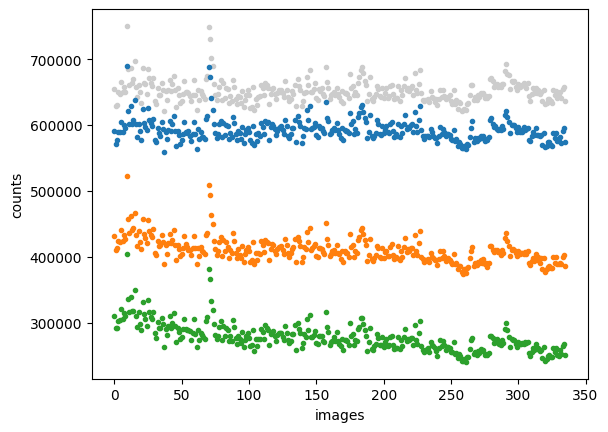

In [7]:
import matplotlib.pyplot as plt

plt.plot(data["fluxes"][:, 5, 20], ".", color="0.8")
plt.plot(data["fluxes"][:, 6, 20], ".")
plt.plot(data["fluxes"][:, 8, 20], ".")
plt.plot(data["fluxes"][:, 10, 20], ".")
plt.xlabel("images")
_ = plt.ylabel("counts")

As expected, the raw fluxes we measured share the same *systematics* signal!

By calculating the ratio of the target star's brightness to that of stable comparison stars, astronomers can effectively cancel out:
- Atmospheric extinction and transparency variations
- Instrumental fluctuations
- Observation timing inconsistencies
- Detector sensitivity changes

**Applications in Modern Astronomy**

This technique has become particularly crucial in several fields:

- Exoplanet Detection: The transit method of detecting exoplanets relies heavily on differential photometry to measure the tiny dips in stellar brightness when a planet passes in front of its host star.
- Variable Star Research: For studying intrinsic stellar variability in pulsating stars, eclipsing binaries, and other variable stars.
- Supernova Monitoring: Tracking the light curves of supernovae as they brighten and fade.
- Asteroid and Minor Planet Studies: Measuring rotation periods and shapes through light curve analysis.

In our case, we are interested in the differential light curve of WASP-12 b. First, we need to identify the star in the field of view. To do that, we need to plate solve the reference image and identify the star using its sky coordinates. Part of that is done in the [plate solving tutorial](plate-solving) and in the [target identification tutorial](target).

In [8]:
target = 5

In order to perform [differential photometry]() *eloy* implements the [Broeg 2005]() algorithm. 

In [9]:
from eloy import flux

# we remove the background from the annulus aperture
fluxes = (data["fluxes"] - data["bkg"]).T

# and perform different photometry
diffs, weights = flux.auto_diff(fluxes, target)

# finally we find the 'optimal' aperture for our target
best_aperture = flux.optimal_flux(diffs[:, target])
diff = diffs[best_aperture, target]

/Users/lionelgarcia/code/eloy/src/eloy/flux.py:97: RuntimeWarning: invalid value encountered in divide
  artificial_light_curve = (sub @ weighted_fluxes) / np.expand_dims(
/Users/lionelgarcia/code/eloy/.venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/lionelgarcia/code/eloy/src/eloy/utils.py:135: RuntimeWarning: Mean of empty slice
  return np.nanmean(


Let's plot the differential flux of our target.

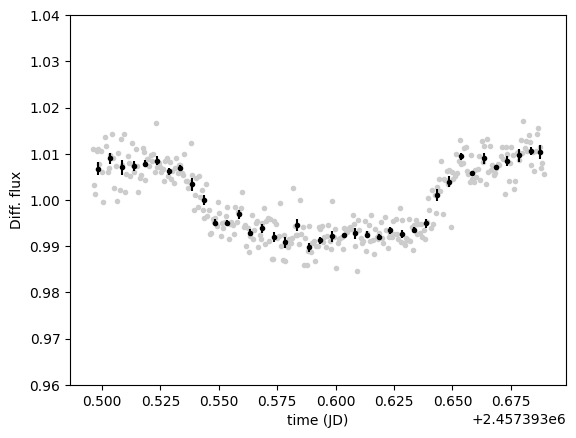

In [10]:
idxs = utils.index_binning(data["time"], 0.005)
binned_time = [data["time"][i].mean() for i in idxs]
binned_diff = [diff[i].mean() for i in idxs]
binned_error = [diff[i].std() / np.sqrt(len(i)) for i in idxs]

plt.plot(data["time"], diffs[best_aperture, target, :], ".", c="0.8")
plt.errorbar(binned_time, binned_diff, yerr=binned_error, fmt=".", c="k")
plt.ylim(0.96, 1.04)
plt.xlabel("time (JD)")
_ = plt.ylabel("Diff. flux")

Looks like a nice transit as expected.

```{note}
The black data points in the plot are binned measurements that reduce visual noise, revealing the true transit shape more clearly than individual observations.
```